In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [450]:
import math
import os.path

import keras
import sklearn
import seaborn
import pandas
import numpy
from matplotlib import pyplot as plt

from microesc import urbansound8k, preprocess, train, test, report, stm32convert, stats, settings, models, features, common


In [73]:
data = urbansound8k.load_dataset()
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


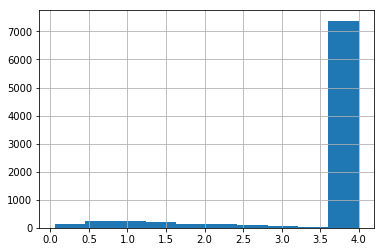

In [157]:
(data.end - data.start).hist()

In [454]:
hist = test.load_train_history('data/models/', '20190501-0223-bd5a')
hist.head()

,epoch,acc,loss,val_acc,val_loss,voted_val_acc,fold,experiment,run,model_path
0,1,0.158667,2.440752,0.261731,2.244147,0.285859,3,8,20190501-0223-bd5a,data/models/8-20190501-0223-bd5a-fold3/e01-v2....
1,2,0.206000,2.280682,0.298654,2.167407,0.327273,3,8,20190501-0223-bd5a,data/models/8-20190501-0223-bd5a-fold3/e02-v2....
2,3,0.228367,2.231905,0.271154,2.143402,0.301010,3,8,20190501-0223-bd5a,data/models/8-20190501-0223-bd5a-fold3/e03-v2....
3,4,0.241067,2.194359,0.321731,2.081261,0.329293,3,8,20190501-0223-bd5a,data/models/8-20190501-0223-bd5a-fold3/e04-v2....
4,5,0.254700,2.162270,0.316923,2.081928,0.342424,3,8,20190501-0223-bd5a,data/models/8-20190501-0223-bd5a-fold3/e05-v2....


In [456]:
# best.nickname == 'Stride-DS-5x5'
best = test.pick_best(hist)
best.head(1)

,,,epoch,acc,loss,val_acc,val_loss,voted_val_acc,fold,experiment,run,model_path
experiment,fold,,,,,,,,,,,
0,0,19,20,0.418133,1.661511,0.638846,1.297131,0.715922,0,0,20190501-0223-bd5a,data/models/0-20190501-0223-bd5a-fold0/e20-v1....


In [461]:
model_path = best.query('fold == "8" and experiment == "3"').model_path[0]
model_path

'data/models/3-20190501-0223-bd5a-fold8/e79-v1.25.t1.59.model.hdf5'

In [100]:
def create_eval_set(fold):
    data = urbansound8k.load_dataset()
    folds, test  = urbansound8k.folds(data)
    test = test.copy()
    train = folds[fold][0].copy()
    val = folds[fold][1].copy()

    test['set'] = 'test'
    train['set'] = 'train'
    val['set'] = 'val'
    # XXX: include train?
    df = pandas.concat([test, val])
    return df
     
eval_set = create_eval_set(fold=8)
print(eval_set.shape)
eval_set.groupby('set').head(2)

(1653, 9)


,slice_file_name,fsID,start,end,salience,fold,classID,class,set
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn,test
10,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn,test
67,101729-0-0-1.wav,101729,0.500000,4.500000,2,9,0,air_conditioner,val
68,101729-0-0-11.wav,101729,5.500000,9.500000,2,9,0,air_conditioner,val


In [108]:
exsettings = settings.load_settings(common.load_settings_path('experiments/ldcnn20k60.yaml'))

def load_sample(sample):
    fsettings = features.settings(exsettings)
    return features.load_sample(sample, fsettings, start_time=sample.start,
                window_frames=exsettings['frames'], feature_dir='data/features')

def predict(model, data):
    return features.predict_voted(exsettings, model, data, loader=load_sample,
                                    method=exsettings['voting'], overlap=exsettings['voting_overlap'])

def model_predict(predictor, model_path, data):
    model = keras.models.load_model(model_path)
    p = predictor(model, data)
    return p

p = model_predict(predict, model_path, eval_set)
eval_set['predictions'] = list(p)
eval_set.groupby('set').head(2)

,slice_file_name,fsID,start,end,salience,fold,classID,class,set,predictions
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn,test,"[0.03206492, 0.12941872, 0.11333097, 0.1137044..."
10,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn,test,"[0.014229942, 0.16539712, 0.066213205, 0.14090..."
67,101729-0-0-1.wav,101729,0.500000,4.500000,2,9,0,air_conditioner,val,"[0.09555469, 0.010715012, 0.03366288, 0.101037..."
68,101729-0-0-11.wav,101729,5.500000,9.500000,2,9,0,air_conditioner,val,"[0.18683255, 0.015797311, 0.06032902, 0.090838..."


In [212]:
eval_set['class'] = eval_set.classID.apply(lambda i: urbansound8k.classnames[i])
eval_set['best_p'] = eval_set.predictions.apply(lambda p: numpy.max(p))
eval_set['best_y'] = eval_set.predictions.apply(lambda p: numpy.argmax(p))
eval_set['correct'] = eval_set.best_y == eval_set.classID
eval_set.head(3)

,slice_file_name,fsID,start,end,salience,fold,classID,class,set,predictions,best_p,best_y,correct
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn,test,"[0.03206492, 0.12941872, 0.11333097, 0.1137044...",0.235730,4,False
10,100648-1-1-0.wav,100648,8.998279,10.052132,2,10,1,car_horn,test,"[0.014229942, 0.16539712, 0.066213205, 0.14090...",0.226467,4,False
11,100648-1-2-0.wav,100648,16.699509,17.104837,2,10,1,car_horn,test,"[0.0050243563, 0.14825162, 0.009926457, 0.1720...",0.342725,4,False


In [210]:
def threshold(df, q=0.8):
    q = df[df.correct == False].best_p.quantile(q=q)
    return q
    
threshold(eval_set[eval_set.set == 'val'])

0.37763323783874514

In [448]:
eval_set[eval_set.set == 'val'].groupby('class').apply(threshold)

class
air_conditioner     0.368953
car_horn            0.383808
children_playing    0.372627
dog_bark            0.357520
drilling            0.555217
engine_idling       0.291193
gun_shot            0.338796
jackhammer          0.632930
siren               0.259379
street_music        0.308365
dtype: float64

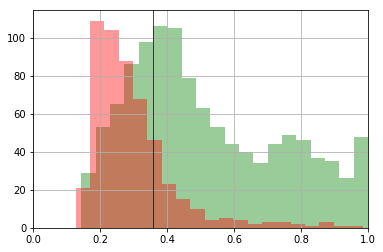

In [398]:
def plot_errors(df, ax=None, q=0.8, bins=20, ylim=None):
    
    if ax is None:
        fig, ax = plt.subplots(1)
    
    (_, wrong), (isright, right) = df.groupby('correct')
    assert isright == True
    
    # FIXME: add legend
    right.best_p.hist(ax=ax, color='green', alpha=0.4, bins=bins)
    wrong.best_p.hist(ax=ax, color='red', alpha=0.4, bins=bins)
    
    ax.set_xlim((0, 1.0))
    if ylim:
        ax.set_ylim(ylim)
    
    # Illustrate a threshold
    if q is not None:
        p_min = threshold(df, q=q)
        ax.axvline(x=p_min, color='black', linewidth=1.0, alpha=0.7)

    return ax
    

plot_errors(eval_set)

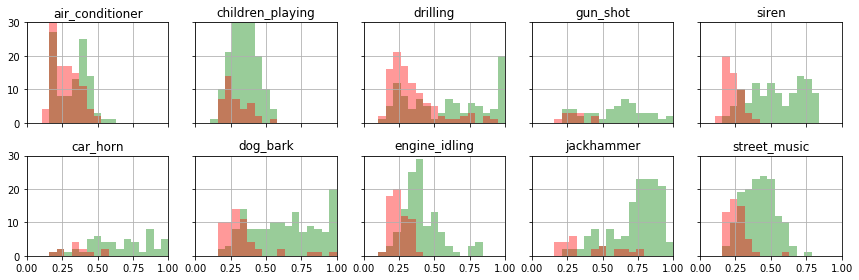

In [407]:
def plot_errors_classwise(df, figsize=(12,4)):

    groups = eval_set.groupby('class')
    fig, axs = plt.subplots(2, len(groups)//2, figsize=figsize)
    
    for i, (classname, data) in enumerate(groups):
        x = i // 2
        y = i % 2
        ax = axs[y, x]
        ax.set_title(classname)
        if x != 0:
            ax.tick_params(labelleft=False)
        if y == 0:
            ax.tick_params(labelbottom=False)
        bins = numpy.linspace(0, 1.0, 20)
        plot_errors(data, ax=ax, ylim=(0, 30), q=None, bins=bins)
    
    fig.tight_layout()
    return fig

plot_errors_classwise(eval_set[eval_set.set == 'val']);

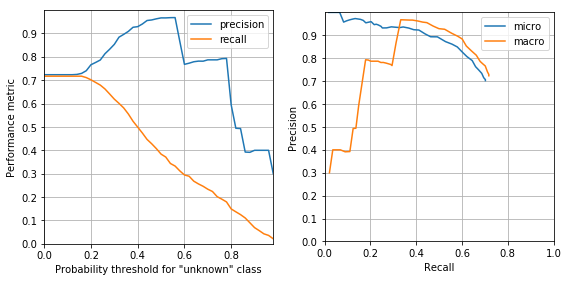

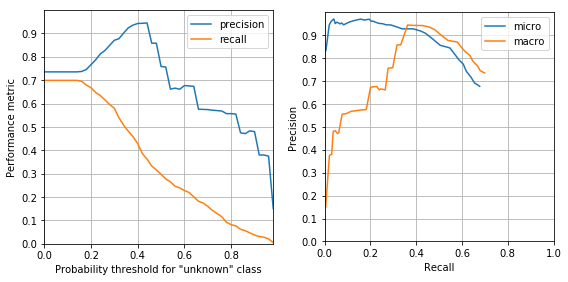

In [447]:
def score(df, average=None, threshold=0.0):
    y_true = df.classID
    y_pred = df.best_y

    uncertain = df.best_p < threshold
    uncertain_ratio = numpy.count_nonzero(uncertain.astype(int)) / len(y_pred)
    y_pred = y_pred.mask(uncertain, 11) # unknown class
  
    labels = list(range(0,10)) # don't count unknown class
    precision = sklearn.metrics.precision_score(y_true, y_pred, average=average, labels=labels)
    recall = sklearn.metrics.recall_score(y_true, y_pred, average=average, labels=labels)
    out = pandas.Series({
        'precision': precision,
        'recall': recall,    
        'uncertain': uncertain_ratio,
    })
    return out

def plot_precision_recall(data, ax=None):
    df = pandas.DataFrame({
        'threshold': numpy.linspace(0, 1.0, 50, endpoint=False)
    })

    micro = df.apply(lambda r: score(data, average='micro', threshold=r.threshold), axis=1)
    micro['threshold'] = df.threshold
    micro['micro'] = micro.precision
    
    macro = df.apply(lambda r: score(data, average='macro', threshold=r.threshold), axis=1)
    macro['threshold'] = df.threshold
    macro['macro'] = macro.precision

    
    fig, (ax2, ax) = plt.subplots(1, 2, figsize=(8, 4))
    
    macro.plot.line(ax=ax2, y=['precision', 'recall'], x='threshold', ylim=(0.0, 1.0))
    
    micro.plot.line(ax=ax, y='micro', x='recall', ylim=(0.0, 1.0), xlim=(0, 1))
    macro.plot.line(ax=ax, y='macro', x='recall', ylim=(0.0, 1.0), xlim=(0, 1))


    ax.set_yticks(numpy.arange(0.0, 1.0, 0.1))
    ax.grid(True)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.set_aspect('equal')
    
    ax2.set_aspect('equal')
    ax2.set_yticks(numpy.arange(0.0, 1.0, 0.1))
    ax2.grid(True)
    ax2.set_xlabel('Probability threshold for "unknown" class')
    ax2.set_ylabel('Performance metric')
    
    fig.tight_layout()

plot_precision_recall(eval_set[eval_set.set == 'val'])
plot_precision_recall(eval_set[eval_set.set == 'test'])

In [17]:
import json

# TODO: check that MACC is correct wrt given by stm32conv
def load_device_results(results_dir):

    frames = []
    
    for filename in os.listdir(results_dir):
        if filename.endswith('.device.json'):
            experiment = filename.rstrip('.device.json')
            p = os.path.join(results_dir, filename)
            with open(p, 'r') as f:
                contents = f.read()
                contents = contents.replace("'", '"') # hack invalid JSON
                d = json.loads(contents)
                d['experiment'] = experiment
                df = pandas.DataFrame([d])
                frames.append(df)

    df = pandas.concat(frames)
    df.set_index('experiment', inplace=True)
    return df

run = '20190412-1024'
results_dir = os.path.join('./data/results', run)
df = load_device_results(results_dir)
df

,cpu_mhz,cycles_avg,cycles_macc,duration_avg,macc,stack
experiment,,,,,,
0,80,77743690,7.632552,0.971796,10185806,388
4,80,5858230,13.551088,0.073227,432307,292
2,80,6527943,13.678647,0.081599,477236,292
3,80,4932455,14.508458,0.061655,339971,292
1,80,26011364,8.726309,0.325142,2980798,276


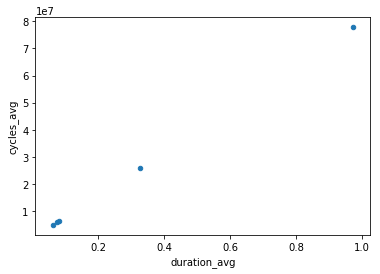

In [18]:
df.plot.scatter(y='cycles_avg', x='duration_avg')

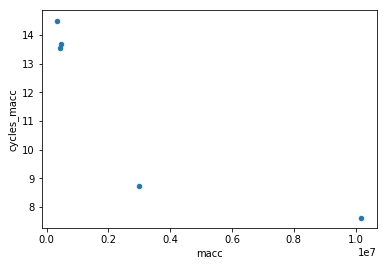

In [20]:
df.plot.scatter(y='cycles_macc', x='macc')

In [22]:
s = {
    'model': 'strided',
    'frames': 31,
    'n_mels': 60,
    'samplerate': 22050,
    'conv_size': (3,3),
    'conv_block': 'effnet',
    'downsample_size': (2,2),
    'n_stages': 3,
    'n_blocks_per_stage': 2,
    'filters': 20,
}
model = models.build(s)
ss, ll = stats.check_model_constraints(model)
ss

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'maccs_frame': 843838,
 'flash_usage': 287460.0,
 'ram_usage_max': 56250.0,
 'ram_usage_min': 56250.0}

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 31, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 30, 16, 20)        200       
_________________________________________________________________
conv0_bn (BatchNormalization (None, 30, 16, 20)        80        
_________________________________________________________________
conv0_relu (Activation)      (None, 30, 16, 20)        0         
_________________________________________________________________
conv1pw (Conv2D)             (None, 30, 16, 10)        200       
_________________________________________________________________
conv1pw_bn (BatchNormalizati (None, 30, 16, 10)        40        
_________________________________________________________________
conv1pw_relu (Activation)    (None, 30, 16, 10)        0         
__________

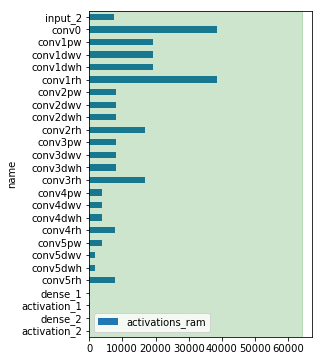

In [24]:
def plot_layers_ram(layers_ram, ax=None, max_ram=64e3):
    
    if not ax:
        fig, ax = plt.subplots(1, figsize=(4, 6))
    
    l = layers_ram.sort_index(ascending=False)
    l['activations_ram'] = 4 * l.activations
    l = l[l.activations_ram.notna()]
    l.plot(kind='barh', ax=ax, y='activations_ram', x='name')
    ax.axvspan(xmin=0, xmax=max_ram, alpha=0.2, color='green')
    
    return fig
    
plot_layers_ram(ll);


In [28]:
model.layers[0].get_output_shape_at(0)

(None, 60, 31, 1)

In [ ]:
# TODO: calculate per-class accuracy. For each fold
# TODO: compare single-frame accuracy (from training) versus voted accuracy
# TODO: compare no-overlap, 50% overlap and 10% overlap